### Import Various Necessary Libraries Dask and Related Libraries

In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask
import os
import sys
import uuid

### Add proxy binaries to path

In [2]:
pwd = !echo ${PWD}

### Extend the local python paths with some network drives

In [3]:
extension_python_paths = ['/datasets/work/oa-roamsurf/work/cmextremes_py/extraction/', os.environ["HOME"] + '/lib/python3.8/site-packages']
[sys.path.append(an_ext) for an_ext in extension_python_paths]

[None, None]

### Specify a python exe used by SLURM to create the dask workers


In [4]:
containered_python_exe = f"srun --export=ALL -n $SLURM_NTASKS -c $SLURM_CPUS_PER_TASK   singularity run {os.environ['SINGULARITY_CONTAINER']} python"

### If you run this cell after creating a cluster it will close that cluster 

In [5]:
try:
    cluster.close()
except:
    pass

### Create a cluster
env_extra sets the worker specific environment parameters   

PYTHONPATH is set to include the extension ptyhon paths and the SINGULARITY_BINDPATH bind paths of this jupyter environment for passing to the workers

In [6]:
job_suffix = os.environ['JOB_SUFFIX'] if 'JOB_SUFFIX' in os.environ.keys() else str(uuid.uuid4())[:8]

## List available project codes

In [7]:
!get_project_codes

/bin/bash: line 1: get_project_codes: command not found


In [8]:
# defined = 'NC_IN_GLOB' in os.environ.keys()
# if not defined:
#     print("WARNING, project code note defined defaulting")
#     project_code = 'OD-215204'
# else:
#     project_code = os.environ['NC_IN_GLOB']

# OD-229130	2023-12-31	Van KIRAP 2.0: GCF Vanuatu Climate Information Services for Resilient Development
project_code = 'OD-229130'

In [9]:
job_extra = f'--account {project_code}'

In [10]:
process_number = 2

In [11]:
cluster = SLURMCluster(
    cores=4, memory="36G", processes=process_number,
    walltime="02:00:00",
    interface='ib0',
    death_timeout=480,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    env_extra=[
              'module load singularity', # ensure singularity is loaded
              'export PYTHONPATH=' + ':'.join(extension_python_paths),
              'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'], 
              'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    # extra = [f'--local-directory={os.environ["SCRATCH2DIR"]}'],
    extra = [f'--local-directory={os.environ["SCRATCH3DIR"]}'],
    python=containered_python_exe,  # use pyhton in container
)

# Debug by running cluster.job_script()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue

## if running a single process based cluster something like this might be needed
```
cluster = SLURMCluster(
    cores=1, memory="24G", processes=1,
    walltime="01:59:00",
    interface='ib0',
    death_timeout=480,
    nanny=False,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    extra = [f' --local-directory={os.environ["SCRATCH2DIR"]}'],
    env_extra=[
    'module load singularity', # ensure singularity is loaded
    'export PYTHONPATH=' + ':'.join(extension_python_paths),
    'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'],
    'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    python=containered_python_exe, # use pyhton in container    
)
```

### Create a client, this will inject dask into xarray and the distributed cluster into dask

In [12]:
client = Client(cluster, timeout=240)
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.150.202.157:39933/status,
Dashboard: http://10.150.202.157:39933/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.150.202.157:41615,Workers: 0
Dashboard: http://10.150.202.157:39933/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
port = client.dashboard_link.split('/')[-2].split(':')[-1]
print(f"Try http://localhost:8888/proxy/{port}/status for the dask dashboard")

Try http://localhost:8888/proxy/39933/status for the dask dashboard


### Scale your workers

With the default config in SLURMCluster above each job will get create 2 workers, one per process and each will have 30gb ram and 4 cores

In [14]:
max_workers = 10

import time
for i in range(0, max_workers): 
    cluster.scale(jobs=i) #yes this looks weird requesting n+1 workers everytime but really it only requests 1 new worker each time
    time.sleep(5)

timeout = 600   # seconds till timeout, timeout if cluster not up in 10 minutes
timeout_start = time.time()
while len(client.ncores().keys())*process_number < max_workers -1:
    if (time.time() > timeout_start+timeout):
        raise Exception(f"Failed to start enough workers in {timeout} seconds, {len(cluster.workers)} started")
    time.sleep(1)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue

In [15]:
len(client.ncores())

8

## Actual original notebook cells to do the work ...

In [16]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import glob

import scipy.stats as stats
import matplotlib.pyplot as plt

/tmp/hoe01e.64743/ipykernel_33961/3451227770.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [17]:
# only run this if above dask cluster cells are notrun
# comment out otherwise
# from dask.distributed import Client, LocalCluster 
# cluster = LocalCluster() # Launches a scheduler and workers locally 
# client = Client(cluster)

In [18]:
# get some pre-defined functions
# probably want to move them somewhere better more accessible
base_path = '/datasets/work/oa-vankirap/work/'
sys.path.append(f'{base_path}/schism/bin')
from SCHISM_load_plot_defs import schism_load, find_nearest_wet_point, schism_plot

### I've been using this package for EVA 
#### https://github.com/georgebv/pyextremes
See https://bitbucket.csiro.au/projects/CMEXTREMES/repos/cmextremes_py/browse/plotting/ww3_test_plot_ts_stats.ipynb
for example usage

In [19]:
from pyextremes import EVA

### This is the hourly 'elev' variable at selected coastal points, concatenated for the entire VanKIRAP Hindcast_v2
i.e.:
    /datasets/work/oa-vankirap/work/schism/Hindcast_v2

data created using:
    ClusterScale_VanKIRAP_SCHISM_extract.ipynb

In [20]:
# coastpoints_ds=xr.open_dataset(f'{base_path}/TWL_calc/coastal_points_schism_elev.nc', chunks='auto')
# coastpoints_ds=xr.load_dataset(f'{base_path}/schism/EVA/coastal_points_schism_elev.nc')
coastpoints_ds=xr.load_dataset(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev.nc', chunks='auto')

In [21]:
coastpoints_ds

<xarray.Dataset>
Dimensions:    (index: 2377, time: 359424)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 2371 2372 2373 2374 2375 2376
  * time       (time) datetime64[ns] 1980-01-01T01:00:00 ... 2021-01-01
Data variables:
    longitude  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    latitude   (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.08 -13.07
    node_idx   (index) int64 97728 97735 97728 97922 ... 3238 3210 3141 3164
    kns        (index) int64 5 10 5 10 10 10 10 5 5 ... 10 10 10 5 10 10 10 10 5
    node_lons  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    node_lats  (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.09 -13.07
    depth      (index) float32 1.11 0.37 1.11 0.0 0.0 ... 24.12 7.08 19.89 2.71
    elev       (time, index) float32 -0.2643 -0.248 ... -0.04502 -0.04967

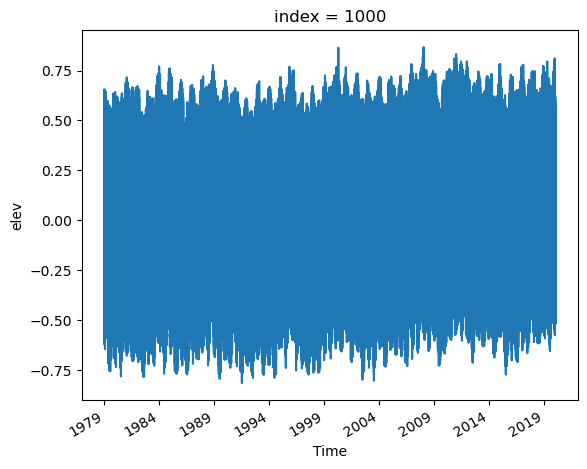

In [22]:
coastpoints_ds.isel(index=1000).elev.plot()

In [23]:
data = coastpoints_ds.elev.isel(index=0).to_series()

return_period = [10, 50, 100]
dist_params = ['thres/loc', 'c', 'scale']

model = EVA(data)
thres = np.percentile(data, 99.8)
model.get_extremes(method="POT", threshold=thres, r="24H")
model.fit_model()

summary = model.get_summary(return_period=return_period, alpha=0.95)

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='elev'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='elev', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

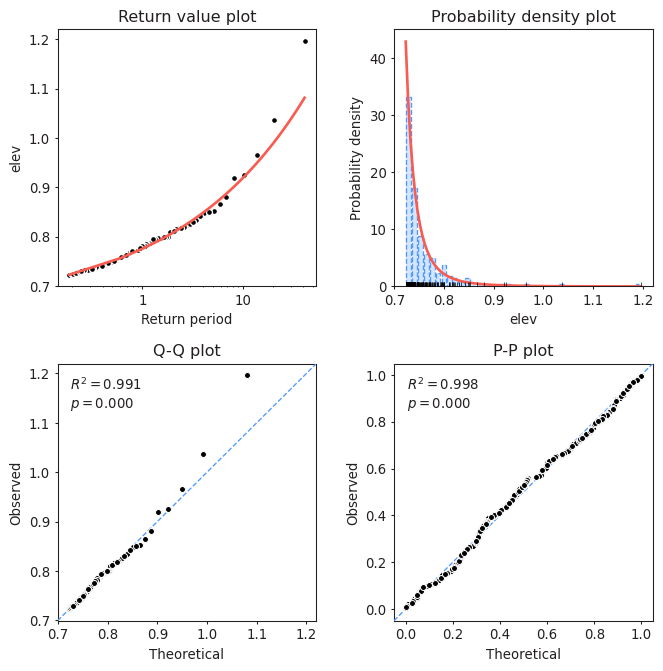

In [24]:
model.plot_diagnostic()

In [25]:
# This cell extracts the "observed" or emperical return period events
from pyextremes import get_extremes, get_return_periods
extremes = get_extremes(
    ts=data,
    method="POT",
    threshold=thres,
    r="24H"
)
observed_return_values = get_return_periods(
    ts=data,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    # return_period_size="365.2425D",
    # plotting_position="weibull",
)
observed_return_values.sort_values("return period", ascending=False).tail()

,elev,exceedance probability,return period
time,,,
2009-03-12 20:00:00,0.722919,0.977477,0.189808
1985-01-19 05:00:00,0.722919,0.981982,0.188937
2012-10-27 05:00:00,0.722762,0.986486,0.188074
2015-01-03 05:00:00,0.722743,0.990991,0.187220
2012-11-15 07:00:00,0.722677,0.995495,0.186372


In [26]:
# This cell finds matching "theoretical" or fitted return period events
observed = observed_return_values.loc[:, model.extremes.name].values
theoretical = model.extremes_transformer.transform(model.model.isf(
    observed_return_values.loc[:, "exceedance probability"].values))

In [27]:
model.extremes_type

'high'

In [28]:
def extremes_R(model, Ryears=5):
    extremes = model.extremes
    observed_return_values = get_return_periods(ts=model.data,
        extremes=model.extremes,
        extremes_method=model.extremes_method,
        extremes_type=model.extremes_type,
        return_period_size="365.2425D")
    
    observed = observed_return_values.loc[:, model.extremes.name].values
    theoretical = model.extremes_transformer.transform(model.model.isf(observed_return_values.loc[:, "exceedance probability"].values))
    
    # pearsonr, p_value = stats.pearsonr(theoretical, observed)
    idx = observed_return_values.loc[:, 'return period'].values>Ryears
    pearsonr, p_value = stats.pearsonr(theoretical[idx], observed[idx])
    return pearsonr, p_value

In [29]:
pearsonr, p_value = extremes_R(model)
print(f'R = {pearsonr}, p = {p_value}')

R = 0.9961269555084045, p = 1.4482217961398312e-07


R = 0.9961269555084045,p = 1.4482217961398312e-07


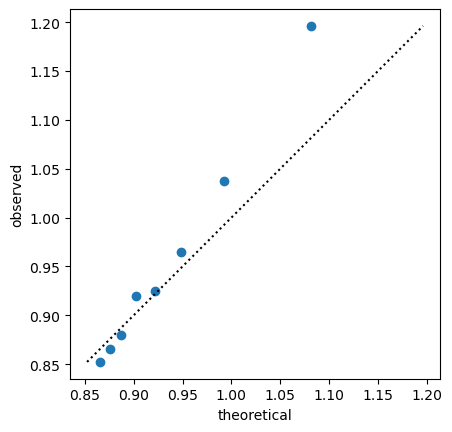

In [30]:
# compare/look at results


pearsonr, p_value = stats.pearsonr(theoretical, observed)
idx = observed_return_values.loc[:, 'return period'].values>5.
pearsonr, p_value = stats.pearsonr(theoretical[idx], observed[idx])
print(f'R = {pearsonr},p = {p_value}')

x_equal_y = np.stack((theoretical[idx], observed[idx])).ravel()
x_equal_y=[x_equal_y.min(),x_equal_y.max()]

plt.scatter(theoretical[idx], observed[idx])
plt.xlabel('theoretical')
plt.ylabel('observed')
plt.plot(x_equal_y,x_equal_y,':k')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#### create dataframe and populate with EVA information (GPD fit parameters, return level, etc)

In [33]:
# create dataframe based on coastpoints_ds and add required fields
coastpoints_eva_df = coastpoints_ds.drop('elev').drop('time').to_dataframe()
return_period = [10, 50, 100]
coastpoints_eva_df['mean'] = coastpoints_ds.elev.mean(dim='time').values
coastpoints_eva_df['max'] = coastpoints_ds.elev.max(dim='time').values
coastpoints_eva_df['p99'] = coastpoints_ds.elev.quantile(0.99, dim='time').values
coastpoints_eva_df['p99.8'] = coastpoints_ds.elev.quantile(0.998, dim='time').values
dist_params = ['R','c', 'scale']
nnodes = coastpoints_eva_df.index.shape
nan_col = np.ones(nnodes)*np.nan

for col in dist_params:
    coastpoints_eva_df[col]=nan_col
for rt in return_period:
    coastpoints_eva_df[f'{rt}']=nan_col
    coastpoints_eva_df[f'{rt} lower ci']=nan_col
    coastpoints_eva_df[f'{rt} upper ci']=nan_col

In [32]:
from tqdm import tqdm



In [33]:
# coastpoints_eva_df

In [34]:
# populated EVA dataframe by fitting EVA/GPD model to each elev timeseries
# for idx in coastpoints_eva_df.index:
#     data = coastpoints_ds.elev.isel(index=idx).to_series()
#     model = EVA(data)
#     thres = np.percentile(data, 99)
#     model.get_extremes(method="POT", threshold=thres, r="24H")
#     try:
#         model.fit_model()
#         summary = model.get_summary(return_period=return_period, alpha=0.95,n_samples=1000,)
#         coastpoints_eva_df.loc[idx,'thres/loc'] = thres
#         for key, val in model.distribution.mle_parameters.items():
#             coastpoints_eva_df.loc[idx,key] = val
#         for rt in return_period:
#             coastpoints_eva_df.loc[idx,f'{rt}'] = summary.loc[rt,'return value']
#             coastpoints_eva_df.loc[idx,f'{rt} lower ci'] = summary.loc[rt,'lower ci']
#             coastpoints_eva_df.loc[idx,f'{rt} upper ci'] = summary.loc[rt,'upper ci']
#     except:
#         print(f'error at point {idx} skipping!')


for idx in tqdm(range(nnodes[0]), desc='Iterations completed'):
    if coastpoints_eva_df['p99.8'].loc[idx]>0.25:
        try:
            data = coastpoints_ds.elev.isel(index=idx).to_series()
            model = EVA(data)
            thres = coastpoints_eva_df['p99.8'].loc[idx]
            model.get_extremes(method="POT", threshold=thres, r="24H")
            model.fit_model()
            summary = model.get_summary(return_period=return_period, alpha=0.95)
            pearsonr, p_value = extremes_R(model)
            coastpoints_eva_df.loc[idx,'R'] = pearsonr
            for key, val in model.distribution.mle_parameters.items():
                coastpoints_eva_df.loc[idx,key] = val
            for rt in return_period:
                coastpoints_eva_df.loc[idx,f'{rt}'] = summary.loc[rt,'return value']
                coastpoints_eva_df.loc[idx,f'{rt} lower ci'] = summary.loc[rt,'lower ci']
                coastpoints_eva_df.loc[idx,f'{rt} upper ci'] = summary.loc[rt,'upper ci']
        except:
            print('*** something is wrong with idx={idx} in node_idxs')

Iterations completed: 100%|██████████| 2377/2377 [08:24<00:00,  4.71it/s]


In [35]:
# Save data out
today = pd.Timestamp('today')
# coastpoints_eva_df.to_csv(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev_EVA_RT.csv')
coastpoints_eva_df.to_csv(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev_POT_p99_8_GPD_ARI_{today:%Y%m%d}.csv')
# load result
# coastpoints_eva_df = pd.read_csv(f'{base_path}/TWL_calc/coastal_points_schism_elev_EVA_RT.csv')

In [36]:
coastpoints_eva_df.to_xarray().to_netcdf(f'{base_path}/schism/Hindcast_v3_coastal_points_schism_elev_POT_p99_8_GPD_ARI_{today:%Y%m%d}.nc')

In [37]:
coastpoints_eva_df[['mean','max','p99','R','c','scale','10','50','100']]

,mean,max,p99,R,c,scale,10,50,100
index,,,,,,,,,
0,0.026832,1.196230,0.643764,0.996127,0.337591,0.023300,0.918817,1.110202,1.230571
1,0.071855,1.423918,0.679135,0.993631,0.314221,0.033246,1.008176,1.236704,1.376804
2,0.026832,1.196230,0.643764,0.996127,0.337591,0.023300,0.918817,1.110202,1.230571
3,0.034949,1.221539,0.647417,0.980270,0.309691,0.023927,0.912351,1.081266,1.184307
4,0.034949,1.221539,0.647417,0.980270,0.309691,0.023927,0.912351,1.081266,1.184307
...,...,...,...,...,...,...,...,...,...
2372,0.066854,0.987597,0.718779,0.970169,NaN,0.036863,0.951300,1.010629,1.036180
2373,0.066938,0.987741,0.718770,0.970313,NaN,0.036949,0.951619,1.011087,1.036698
2374,0.066774,0.987676,0.718459,0.973295,NaN,0.037410,0.952763,1.012972,1.038903


In [46]:
stride = 25
for idx in np.arange(0, len(coastpoints_eva_df.index)+1, stride):
    row=coastpoints_eva_df.iloc[[idx]]
    node_idx = row['node_idx'].values[0]
    data = coastpoints_ds.elev.isel(index=idx).to_series()
    model = EVA(data)
    thres = np.percentile(data, 99.8)
    model.get_extremes(method="POT", threshold=thres, r="24H")
    model.fit_model()
    fig,ax =  model.plot_return_values(alpha=0.95)
    ax.set_title(f'Water Level, node {node_idx}')
    ax.set_ylabel('$elev$ (m)')
    ax.set_xticks([1,5,10,50])
    ax.set_xlim([0.5,50])
    ax.set_xlabel('Return period (years)')
    fig.savefig(f'{base_path}/schism/EVA/plots/SCHISM_Hindcastv3_RIplot_elev_node_{node_idx}.png')
    # fig.clear()
    plt.close()

In [47]:
coastpoints_ds.isel(index=np.where(coastpoints_ds.node_idx==95913)[0])
                    

<xarray.Dataset>
Dimensions:    (index: 0, time: 359424)
Coordinates:
  * index      (index) int64 
  * time       (time) datetime64[ns] 1980-01-01T01:00:00 ... 2021-01-01
Data variables:
    longitude  (index) float64 
    latitude   (index) float64 
    node_idx   (index) int64 
    kns        (index) int64 
    node_lons  (index) float64 
    node_lats  (index) float64 
    depth      (index) float32 
    elev       (time, index) float32

In [48]:
# coastpoints_ds.isel(index=np.where(coastpoints_ds.node_idx==95913)[0]).isel(index=0).elev.plot()

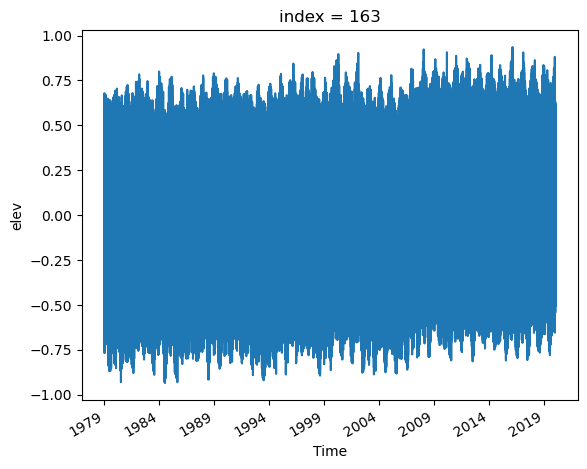

In [49]:
coastpoints_ds.isel(index=163).elev.plot()

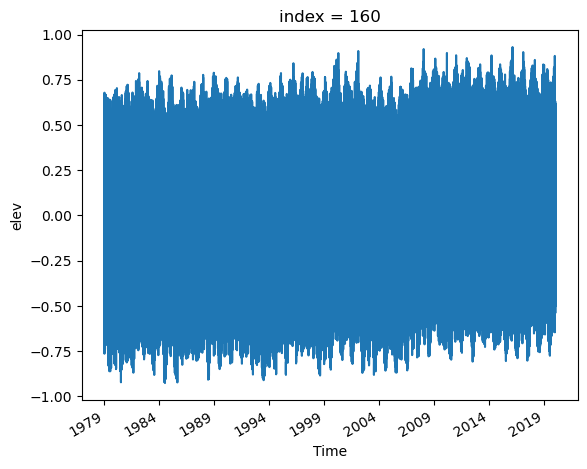

In [50]:
coastpoints_ds.isel(index=np.where(coastpoints_ds.node_idx==95878)[0]).isel(index=0).elev.plot()

In [51]:
# coastpoints_ds.isel(index=np.where(coastpoints_ds.node_idx==95913)[0]).isel(index=1).elev.plot()

In [52]:
[coastpoints_ds.isel(index=np.where(coastpoints_ds.node_idx==73379)[0])['longitude'].values[0],
 coastpoints_ds.isel(index=np.where(coastpoints_ds.node_idx==73379)[0])['latitude'].values[0]]

[168.32461861500744, -17.743705282625317]

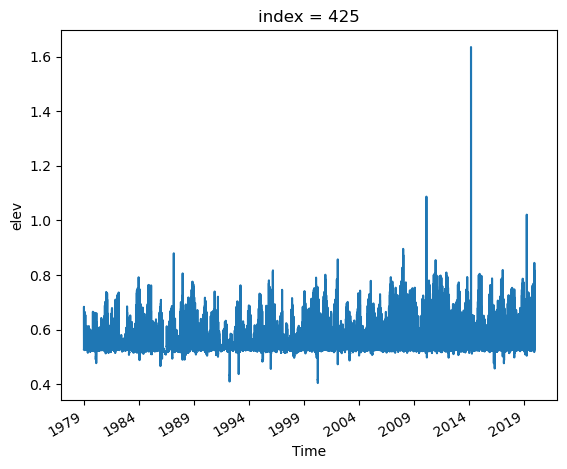

In [53]:
coastpoints_ds.isel(index=np.where(coastpoints_ds.node_idx==73379)[0]).elev.plot()